# **Liver Tumour Segmentation with U-Net**
The aim of this project is to segment Liver tumor from CT image using [U-Net](https://arxiv.org/abs/1505.04597). The project is inspired by my Advance Machine Learning Module at King's College London led by Dr Jorge Cardoso and Dr Emma Robinson.

The data used in this coursework is a 3D dataset of 131 volumetric CT images and their labels. And another 70 volumetric CT images with no labels.

# **Part 1 - Load and Create Dataset**


The data used in this coursework is a 3D dataset of 131 volumetric CT images and their labels. Because the size of the dataset is small, 131 images would be splitted into train, validation, and test sets with a ratio of 90 - 5 - 5.

In [1]:
# Reset the notebook when a lot of memories were leaked
# %reset
import torch
print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 2):.2f} MB")
# Show CPU RAM to avoid overflowing the memory
import psutil
# Get the current RAM usage
memory = psutil.virtual_memory()
# Print the RAM usage information
print(f"Total RAM: {memory.total / (1024.0 ** 2):.2f} MB")
print(f"Available RAM: {memory.available / (1024.0 ** 2):.2f} MB")
print(f"Used RAM: {memory.used / (1024.0 ** 2):.2f} MB")
print(f"RAM Usage: {memory.percent}%")

Allocated GPU memory: 0.00 MB
Total GPU memory: 15095.06 MB
Total RAM: 32110.16 MB
Available RAM: 30597.14 MB
Used RAM: 1056.80 MB
RAM Usage: 4.7%


In [2]:
# Import library and set up environment
# General library
import os as os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 
print("Number of GPU workers available:", torch.cuda.device_count())
# Specific library needed for the project
import nibabel as nib
import random

cuda
Number of GPU workers available: 2


In [3]:
# For Kaggle
# Exploring Kaggle environment
def list_folder_tree(path, indent=''):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(indent + '📁 ' + item)  # Print folder name
            list_folder_tree(item_path, indent + '  ')  # Recursively explore subfolders
#         else:
#             print(indent + '📄 ' + item)  # Print file name

def list_current_folder_tree(path, indent=''):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(indent + '📁 ' + item)  # Print folder name
        else:
            print(indent + '📄 ' + item)  # Print file name
# Specify the root folder path
root_path = '/kaggle/input/u-net-liver-cancer/Task03_Liver'
# Call the function to list the folder tree
list_current_folder_tree(root_path)

📁 imagesTs
📄 ._labelsTr
📁 labelsTr
📄 ._imagesTr
📄 ._imagesTs
📁 imagesTr
📄 ._dataset.json
📄 dataset.json


In [4]:
import json
# Open the JSON file
with open(os.path.join(root_path, "dataset.json"), 'r') as file:
    # Load the JSON data into a Python object (usually a dictionary)
    data = json.load(file)
    
# # Work with the data: Print all file in the dataset.json
print(data.keys())
    
# Get important information
labels_dict = data["labels"]
print(f"Labels dict: {labels_dict}")
# Get meata data and print 3 train file data
data_dict = data["training"]
print(type(data_dict))
dataset_length = len(data_dict)
print(f"Dataset length: {dataset_length}")
for i, file_data in enumerate(data_dict):
    file_data['image'] = os.path.join(root_path, file_data['image'][2:-3])
    file_data['label'] = os.path.join(root_path, file_data['label'][2:-3])
for i, file_data in enumerate(data_dict):
    print(file_data)
    if i == 3:
        break

dict_keys(['name', 'description', 'reference', 'licence', 'release', 'tensorImageSize', 'modality', 'labels', 'numTraining', 'numTest', 'training', 'test'])
Labels dict: {'0': 'background', '1': 'liver', '2': 'cancer'}
<class 'list'>
Dataset length: 131
{'image': '/kaggle/input/u-net-liver-cancer/Task03_Liver/imagesTr/liver_14.nii', 'label': '/kaggle/input/u-net-liver-cancer/Task03_Liver/labelsTr/liver_14.nii'}
{'image': '/kaggle/input/u-net-liver-cancer/Task03_Liver/imagesTr/liver_69.nii', 'label': '/kaggle/input/u-net-liver-cancer/Task03_Liver/labelsTr/liver_69.nii'}
{'image': '/kaggle/input/u-net-liver-cancer/Task03_Liver/imagesTr/liver_77.nii', 'label': '/kaggle/input/u-net-liver-cancer/Task03_Liver/labelsTr/liver_77.nii'}
{'image': '/kaggle/input/u-net-liver-cancer/Task03_Liver/imagesTr/liver_120.nii', 'label': '/kaggle/input/u-net-liver-cancer/Task03_Liver/labelsTr/liver_120.nii'}


In [6]:
# Split the data into train - val - test 90 - 5 - 5 by getting their index
numbers = list(range(131))
random.shuffle(numbers)
val_test_size = int(dataset_length*5/100)
train_idx = numbers[:-2*val_test_size]
val_idx = numbers[-2*val_test_size:-val_test_size]
test_idx = numbers[-val_test_size:]
# Confirm the split
print(f"Total length: {len(train_idx) + len(val_idx) + len(test_idx)}")
print(f"{test_idx}")

Total length: 131
[103, 124, 129, 13, 111, 36]


## Function to visualize the data

In [7]:
import ipywidgets
from ipywidgets import interact, IntSlider

def get_index_around_tumour(x):
    """Get the index of the area with tumour (Class = 2)"""
    x=x.squeeze().flip((0,1,2))
    indices=torch.where(x==2)
    middle_point = len(indices[0])//2
    indices = [index[middle_point].detach().item() for index in indices]
    return indices[0], indices[1], indices[2]

# LOAD THE DATASET AND LABELS
def open_and_get_image_data(path, file_name):
    image = nib.load(os.path.join(path, file_name))
    nii_data = image.get_fdata()
    tensor = torch.from_numpy(nii_data)
    return tensor.permute(2,1,0)

def plt_3D(image, depth=None, height=None, width=None, cmap = "gray", vmin=None, vmax=None):
    # Remove redundant dimension
    if image.dim() >= 4:
        image = image.squeeze()
    # Flip to get conventional clinical view
    image = image.flip(dims=(0,1,2))
    # Detach if needed
    image = image.detach().cpu()
    # Decide which slide to plot
    depth=depth if (depth is not None) else image.size(0)//2
    height=height if (height is not None) else image.size(2)//2
    width=width if (width is not None) else image.size(1)//2
    print(depth, height, width)
    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    ax1.imshow(image[depth,:,:], cmap = cmap, vmin=vmin, vmax=vmax)
    ax2.imshow(image[:,height,:], cmap = cmap, vmin=vmin, vmax=vmax)
    ax3.imshow(image[:,:,width], cmap = cmap, vmin=vmin, vmax=vmax)
    plt.show()
    plt.close(fig)
    
def plt_3D_interactive(image, cmap="gray"):
    """Plot interactive images"""
    # Remove redundant dimension
    if image.dim() >= 4:
        image = image.squeeze()
    # Interactive widgets
    depth_slider = IntSlider(min=0, max=image.shape[0]-1, step=1, value=image.shape[0]//2, description='Depth')
    height_slider = IntSlider(min=0, max=image.shape[1]-1, step=1, value=image.shape[1]//2, description='Height')
    width_slider = IntSlider(min=0, max=image.shape[2]-1, step=1, value=image.shape[2]//2, description='Width')
    interact(plt_3D, image=ipywidgets.fixed(image), depth=depth_slider, height=height_slider, width=width_slider,
             cmap=ipywidgets.fixed(cmap), vmin=ipywidgets.fixed(None), vmax=ipywidgets.fixed(None))

15 328 194


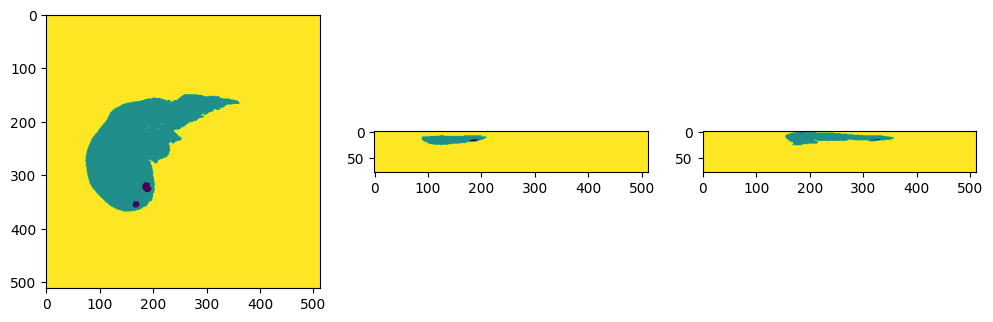

15 328 194


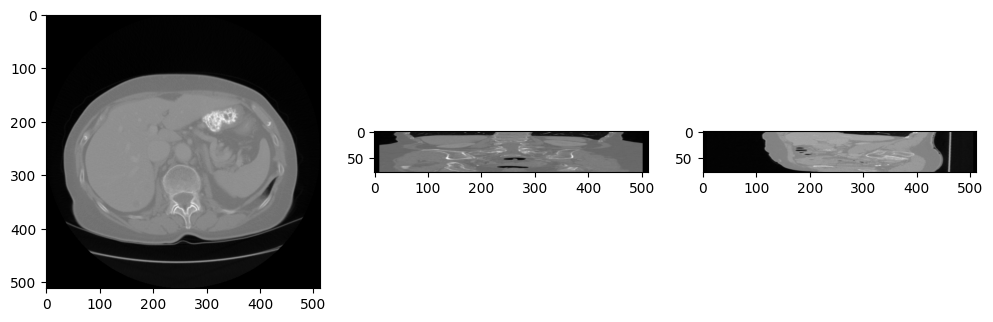

131 193 218


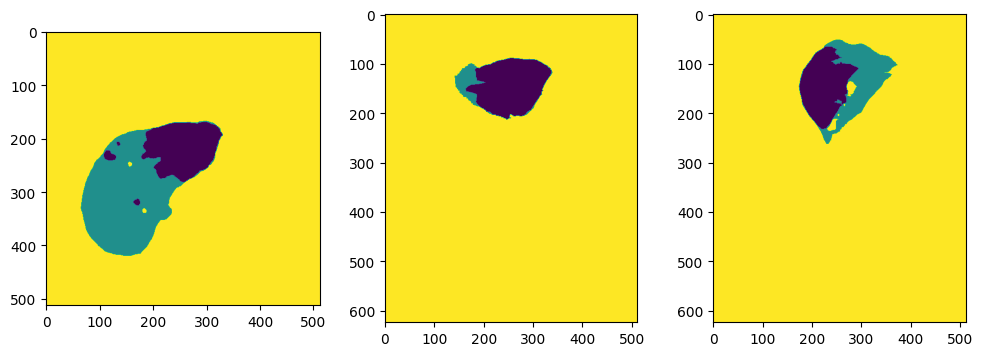

131 193 218


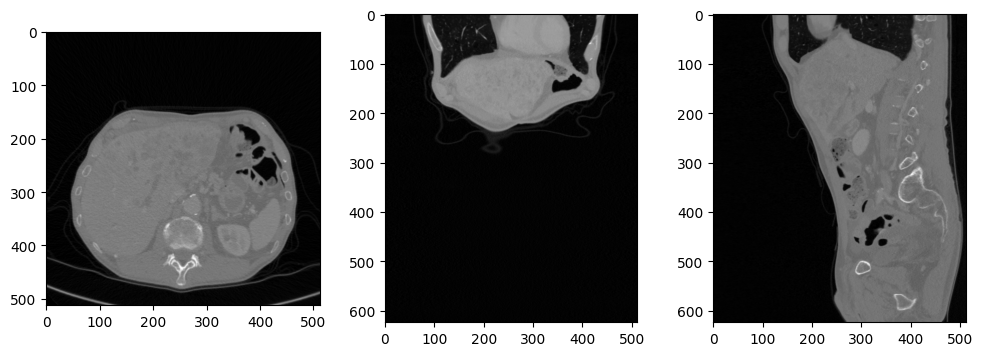

In [39]:
# Open 2 images, 2 labels to view
file_name = "labelsTr/liver_0.nii"
tensor = open_and_get_image_data(root_path, file_name)
d, h, w = get_index_around_tumour(tensor)
plt_3D(tensor, d, h, w, cmap = "viridis_r")
file_name = "imagesTr/liver_0.nii"
tensor = open_and_get_image_data(root_path, file_name)
plt_3D(tensor, d, h, w)
file_name = "labelsTr/liver_130.nii"
tensor = open_and_get_image_data(root_path, file_name)
d, h, w = get_index_around_tumour(tensor)
plt_3D(tensor, d, h, w, cmap = "viridis_r")
file_name = "imagesTr/liver_130.nii"
tensor = open_and_get_image_data(root_path, file_name)
plt_3D(tensor, d, h, w)


312 256 256


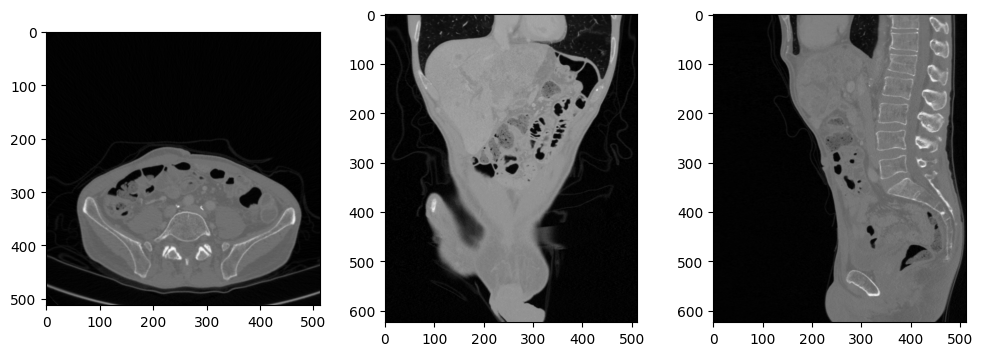

In [23]:
# Test
file_name = "imagesTr/liver_130.nii"
tensor = open_and_get_image_data(root_path, file_name)
plt_3D_interactive(tensor)

In [10]:
# Summary about the data: get 10 image and get their mean, std of pixel
image_stack = []
max_size = 512
min_size = 512
# max_liver_size = 0
# min_liver_size = 1
for i in val_idx:
    # open the image
    file_name = f"imagesTr/liver_{i}.nii"
    image = open_and_get_image_data(root_path, file_name)
    # Get max and min size
    if image.size(0) > max_size:
        max_size = image.size(0)
    if image.size(0) < min_size:
        min_size = image.size(0)
#     # Get the depth of liver window
#     non_zero_index = torch.nonzero(image)
#     liver_range = non_zero_index[:,0].max() - non_zero_index[:,0].min()
#     liver_range = liver_range/image.size(0)
#     # Get max and min liver window size
#     if liver_range > max_liver_size:
#         max_liver_size = liver_range
#     if liver_range < min_liver_size:
#         min_liver_size = liver_range
    image_stack.append(image)
image_stack = torch.concat(image_stack, dim = 0)
# non_zero_image_stack = image_stack[image_stack>0]
# image_mean=non_zero_image_stack.mean().item()
# image_std=non_zero_image_stack.std().item()
print(f"Image mean {image_stack.mean()}")
print(f"Image std {image_stack.std()}")
print(f"Image min {image_stack.min()}")
print(f"Image max {image_stack.max()}")
print(f"Estimated min image size {min_size} MB")
print(f"Estimated max image size {max_size} MB")
# print(f"Estimated min liver size {min_liver_size}")
# print(f"Estimated max liver size {max_liver_size}")
print(f"Estimated mean image size {image_stack.size(0)/len(val_idx)} MB")
print(f"Combined size {image_stack.size()}")
del image_stack

Image mean -583.1864213943481
Image std 499.2126343967774
Image min -1024.0
Image max 8849.0
Estimated min image size 237 MB
Estimated max image size 756 MB
Estimated mean image size 485.3333333333333 MB
Combined size torch.Size([2912, 512, 512])


## Comment
The data have a dimension of (Depth, Width, Height) = (Depth, 512, 512) where the Depth might range in 64-1024 (Due to different spacing of CT slides).

Each image is very large: 64-1024 MB. The average image size is around 512MB => Max GPU memory of Kaggle is about 14GB => Batchsize of 8. (consider the memory used in the network => batchsize = 2 for 2 GPU)


# Load the data

Test: 6
Dataset: train size 119, validation size 6, test size 6
Execute time: 9.822521488000007
32 64 64


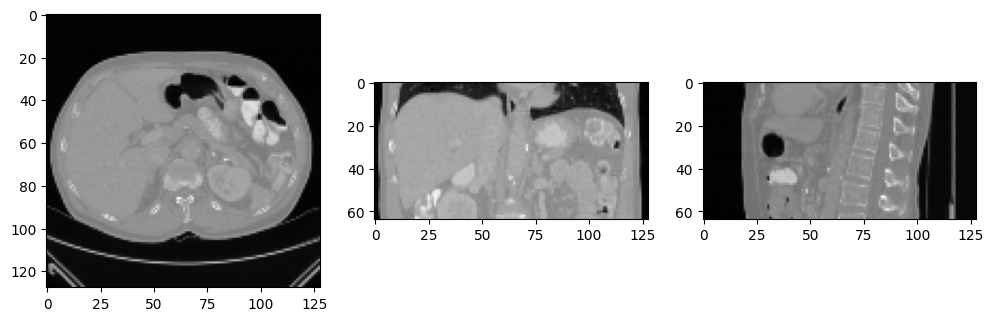

32 64 64


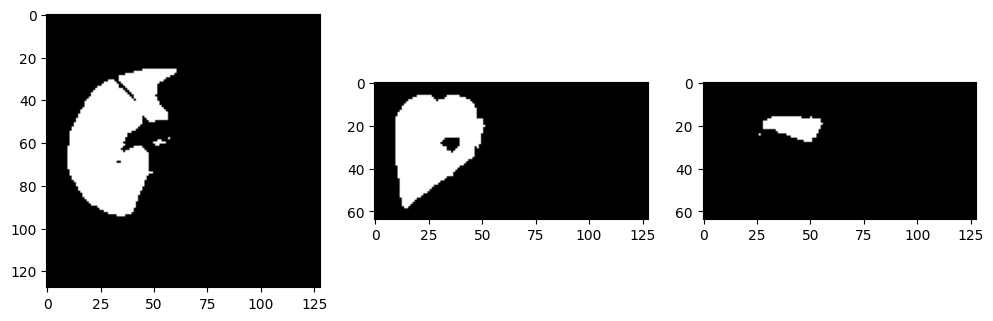

tensor(-5.3700)
tensor(5.6959)


In [8]:
from torchvision.transforms import Compose, Normalize
import copy

# CREATE DATASET AND DATALOADERS (NO DATA AUGMENTATION)
# DATASET

# image_mean=image_stack.mean()
# image_std=image_stack.std()
# print(f"Image mean {image_mean}")
# print(f"Image std {image_std}")

# The tissue window of CT image is from -150 to 250
image_mean=50.0
image_std=200.0

# Define the full transform
image_transform = Compose([
    Normalize(mean=image_mean, std=image_std),
])

class liver_image_dataset(Dataset):
    def __init__(self, data_dict, data_idx, image_transform=None,
                 image_augmentation_transform=None, both_augmentation_transform=None,
                 output_size=(64, 128, 128)):
        # Store meta data and path
        self.data_dict=data_dict
        self.data_idx=data_idx
        self.image_transform=image_transform
        self.image_augmentation_transform=image_augmentation_transform
        self.both_augmentation_transform=both_augmentation_transform       
        self.output_size = output_size
        # Check the data dict contain all data_idx. And data path contain all file in data_dict
        for idx in data_idx:
            try:
                assert os.path.exists(data_dict[idx]["image"]), "Cannot find image"
                assert os.path.exists(data_dict[idx]["label"]), "Cannot find label"                
            except IndexError:
                assert False, "One of data_idx is not available in data_dict"        
    def __len__(self):
        # Return length of datasetss
        return len(self.data_idx)
    def __getitem__(self, index):
        # Go into the folder with file name and read data
        image = open_and_get_image_data("/", self.data_dict[index]["image"])
        label = open_and_get_image_data("/", self.data_dict[index]["label"])
        # Transformation of data
        if self.image_transform:
            image = self.image_transform(image)
        # Get the windows with only liver
        depth = image.size(0)
        non_zero_index = torch.nonzero(label)
        depth_max = non_zero_index[:,0].max().item() + int(depth/50)
        depth_min = non_zero_index[:,0].min().item() - int(depth/50)
        depth_max = min(depth_max, depth)
        depth_min = max(depth_min, 0)
        image = image[depth_min:depth_max,:,:]
        label = label[depth_min:depth_max,:,:]        
        # Resize all images into 1 desired size(256, 512, 512)
        image = image.unsqueeze(0).unsqueeze(0)
        label = label.unsqueeze(0).unsqueeze(0)
        image = F.interpolate(image, size=self.output_size, mode='trilinear', align_corners=False)
        label = F.interpolate(label, size=self.output_size, mode='nearest')
        image = image.squeeze()
        label = label.squeeze()        
        # MAKE SURE THE AUGMENTATION IS IMPLEMENTED AFTER image_transform WHICH IS STANDARD TRANSFORM
        if self.both_augmentation_transform:
            self.both_augmentation_transform.generate_transform(image)
            image=self.both_augmentation_transform.apply_transform_on_image(image)
            label=self.both_augmentation_transform.apply_transform_on_label(label)
        if self.image_augmentation_transform:
            image = self.image_augmentation_transform(image)
        image = image.unsqueeze(0)
        # Convert data to desired type
        image = image.to(torch.float)
        label = label.to(torch.long)
        return image, label

# Test
test = liver_image_dataset(data_dict, val_idx)
print(f"Test: {len(test)}")
# print(f"Test: {test[0][0].min()}")
# print(f"Test: {test[0][0].max()}")
# print(f"Test: {test[0][0].size()}")
# print(f"Test: {test[0][1].size()}")
# print(f"Test: {test[0][0].dtype}")
# print(f"Test: {test[0][1].dtype}")

# Create dataset
output_size=(64, 128, 128)
train_dataset_raw = liver_image_dataset(data_dict, train_idx, image_transform=image_transform,
                                        image_augmentation_transform=None, both_augmentation_transform=None,
                                        output_size=output_size)
val_dataset = liver_image_dataset(data_dict, val_idx,
                                  image_transform=image_transform,
                                  output_size=output_size)
test_dataset = liver_image_dataset(data_dict, test_idx,
                                   image_transform=image_transform,
                                   output_size=output_size)
# Test
print(f"Dataset: train size {len(train_dataset_raw)}, validation size {len(val_dataset)}, test size {len(test_dataset)}")
start_time = time.perf_counter()
test_data = test_dataset[0]
print(f"Execute time: {time.perf_counter()-start_time}")
plt_3D(test_data[0], cmap = "gray")
plt_3D(test_data[1], cmap = "gray")
print(test_data[0].min())
print(test_data[0].max())
del test_data

# **Part 2 - U-Net to segment the liver tumor**

In this section, I will create a U-Net model to perform a supervised segmentation task.
The architecture could be found [here](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

## Define some function for calculating the loss and validation

In [10]:
# Define loss function
# Loss function: My dice loss
def dice_loss(prediction, truth):
    """Calculate 1 - generalized_dice_score
    The truth need to be one-hot encoded"""
    assert truth.max()<=1, "The truth need to be one-hot encoded"
    assert truth.min()>=0, "The truth need to be one-hot encoded"
    total_dim = truth.dim() #Dimension of input (4 for 2D image and 5 for 3D)
    # Count the number of class and get the weights
    # Calculate the loss
    numerator = torch.sum(truth*prediction, dim = tuple(range(2,total_dim)))
    denominator = torch.sum((truth**2+prediction**2), dim = tuple(range(2,total_dim)))
    dice = torch.where(denominator!=0,2* (numerator) / (denominator),denominator)
    dice = dice.mean(dim=1)
    return 1-dice.mean()
x = torch.rand(7,5,64,64,64)
y = torch.randint(0, 2, size=(7,5,64,64,64), dtype=torch.long)
y2 = y.to(torch.float)
print(dice_loss(x,y))
print(dice_loss(y2,(1-y)))
print(dice_loss(y2,y))

# Loss function: My generalized dice loss
def generalized_dice_loss(prediction, truth):
    """Calculate 1 - generalized_dice_score
    The truth need to be one-hot encoded"""
    assert truth.max()<=1, "The truth need to be one-hot encoded"
    assert truth.min()>=0, "The truth need to be one-hot encoded"
    epsilon=1e-6
    total_dim = truth.dim() #Dimension of input (4 for 2D image and 5 for 3D)
    # Count the number of class and get the weights
    weights = truth.sum(dim=tuple(range(2,total_dim)))
#     weights = weights**2
    weights = torch.where(weights!=0, 1/(weights), weights)
    # Normalize the weight
    weights = weights/weights.sum(dim=1).unsqueeze(1)
    # Calculate the loss
    numerator = torch.mean(truth*prediction, dim = tuple(range(2,total_dim)))
    denominator = torch.mean((truth**2+prediction**2), dim = tuple(range(2,total_dim)))
#     print(weights)
    dice = 1 - (2* (numerator+epsilon) / (denominator+epsilon))
#     print(dice.detach().cpu())
    dice = (dice*weights).sum(dim=1)
    return dice.mean()
x = torch.rand(1,3,64,128,128)
# print(x.max())
y = torch.randint(0, 2, size=(1,3,64,128,128), dtype=torch.long)
y2 = y.to(torch.float)
print(generalized_dice_loss(x,y))
print(generalized_dice_loss(y2,(1-y)))
print(generalized_dice_loss(y2,y))

tensor(0.4001)
tensor(1.)
tensor(0.)
tensor(0.4003)
tensor(1.0000)
tensor(-1.0729e-06)


In [11]:
# My dice score: Calculate dice score instead of dice loss
def dice_score_one_minus(prediction, truth):
    """Calculate 1 - dice_score
    The truth need to be one-hot encoded"""
    assert truth.max()<=1, "The truth need to be one-hot encoded"
    assert truth.min()>=0, "The truth need to be one-hot encoded"
    total_dim = truth.dim() #Dimension of input (4 for 2D image and 5 for 3D)
    # Count the number of class and get the weights
    # Calculate the loss
    prediction_result = prediction >= 0.5
    numerator = torch.sum(truth*prediction_result, dim = tuple(range(2,total_dim)))
    denominator = torch.sum((truth**2+prediction_result**2), dim = tuple(range(2,total_dim)))
    dice = 2* (numerator) / (denominator)
    dice = dice.mean(dim=1)
    return 1-dice.mean()
x = torch.rand(7,5,64,64,64)
y = torch.randint(0, 2, size=(7,5,64,64,64), dtype=torch.long)
y2 = y.to(torch.float)
print(dice_score_one_minus(x,y))
print(dice_score_one_minus(y2,(1-y)))
print(dice_score_one_minus(y2,y))

tensor(0.4998)
tensor(1.)
tensor(0.)


## Define some network architectures and the main network

In [12]:
# Define a block for double convolution
class base_double_3D_conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=None):
        '''
        in_channels - integer - the number of feature channels the first
                              convolution will receive
        out_channels - integer - the number of feature channels the last
                               convolution will output
        '''
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=(3,3,3), padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout, inplace=False) if dropout else nn.Identity(),
            nn.Conv3d(out_channels, out_channels, kernel_size=(3,3,3), padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout, inplace=False) if dropout else nn.Identity(),
        )
    def forward(self, x):
        return self.double_conv(x)

# Test
test = base_double_3D_conv_block(3, 16, dropout=0.5)
x = torch.rand((3, 3, 32, 64, 64))
print(x.size())
t = time.perf_counter()
print(test(x).size())
print(time.perf_counter()-t)

torch.Size([3, 3, 32, 64, 64])
torch.Size([3, 16, 32, 64, 64])
0.256478871000013


## Main network

Memory allocated: 0.00 MB
Total number of parameters: 22578339
Memory allocated: 88.98 MB
Memory allocated: 92.98 MB
torch.Size([1, 1, 64, 128, 128])
torch.Size([1, 3, 64, 128, 128])
Memory allocated: 2722.01 MB
Memory allocated: 193.81 MB
Execute time 1.366651915000034
torch.Size([1, 64, 128, 128])
32 64 64


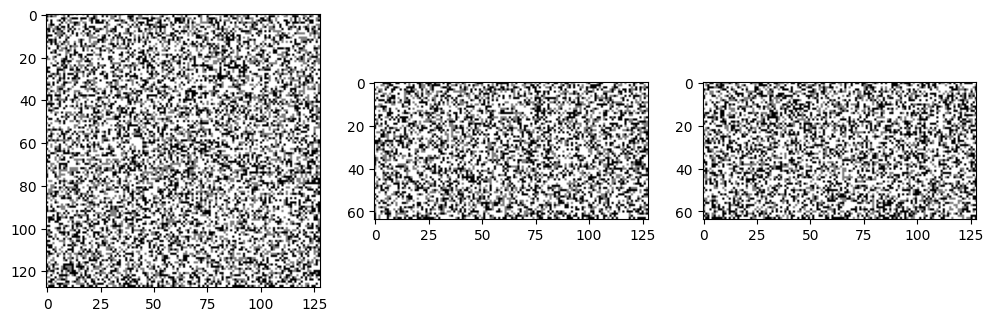

In [13]:
class My3DUNet_1(nn.Module):
    def __init__(self, depth = 4, in_channels=1, complexity=64, num_class=3, dropout=None):
        super().__init__()
        # Declare the dict
        modules = nn.ModuleDict()
        # First double comv layer
        feature_size=complexity
        modules[f"double_layers_down_{0}"] = base_double_3D_conv_block(in_channels=in_channels,
                                                                       out_channels=feature_size,
                                                                       dropout=dropout,)       
        # Downsample and then double conv the network for a depth total of time
        for d in range(1, depth+1, 1):
            # Reset in_channels and doubling the feature_size
            in_channels = feature_size
            feature_size *= 2
            # Downsampling first with stride conv layer
            modules[f"downsample_{d}"] = nn.MaxPool3d(kernel_size=2, stride=2)
            modules[f"double_layers_down_{d}"] = base_double_3D_conv_block(in_channels=in_channels,
                                                                           out_channels=feature_size,
                                                                           dropout=dropout)
        # Upsample and then double conv the network for a depth total of time
        for d in range(depth-1, -1, -1):
            # Reset in_channels and doubling the feature_size
            in_channels = feature_size
            feature_size //= 2
            # Downsampling first with stride conv layer
            modules[f"upsample_{d}"] = nn.Sequential(
                nn.ConvTranspose3d(
                    in_channels=in_channels,
                    out_channels=feature_size,
                    kernel_size=2,
                    stride=2,
                ),
#                 nn.BatchNorm3d(feature_size),
#                 nn.ReLU(),                
            )
            modules[f"double_layers_up_{d}"] = base_double_3D_conv_block(in_channels=feature_size+feature_size,
                                                                         out_channels=feature_size,
                                                                         dropout=dropout,)
        # Last layer to project to number of class
        in_channels=feature_size
        feature_size=num_class
        modules[f"last_layers_to_classification"] = nn.Conv3d(in_channels=in_channels,
                                                              out_channels=feature_size,
                                                              kernel_size=1,
                                                              stride=1,
                                                              padding=0)
        self.my_modules = modules
        # Store the depth and the number of class
        self.depth=depth
        self.num_class=num_class

#         Initiate the weights
        self.initialize_weights()
        
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Conv3d,
                                   nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d,
                                   nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Store layer for skip connection
        stored_layer = {}
        # Downward path
        for d in range(0, self.depth, 1):
            stored_layer[d] = self.my_modules[f"double_layers_down_{d}"](x)
            x = self.my_modules[f"downsample_{d+1}"](stored_layer[d])
        # Bottleneck layer
        x = self.my_modules[f"double_layers_down_{self.depth}"](x)
        # Upward path
        for d in range(self.depth-1, -1, -1):
            x = self.my_modules[f"upsample_{d}"](x)
            x = torch.concat([x,stored_layer[d]], dim=1)            
            x = self.my_modules[f"double_layers_up_{d}"](x)
        x = self.my_modules[f"last_layers_to_classification"](x)
        return F.softmax(x, dim=1)

depth = 4
in_channels=1
complexity=32
num_class=3
dropout=0.5
# Test
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")
test = My3DUNet_1(depth=depth, in_channels=in_channels, complexity=complexity, num_class=num_class, dropout=dropout)
test = test.to(device)
test.train()
total_params = sum(p.numel() for p in test.parameters())
print(f"Total number of parameters: {total_params}")
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")
x = torch.rand((1, 1, 64, 128, 128)) # Test to find maximal batch_size that I should use
start_time = time.perf_counter()
x = x.to(device)
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")
print(x.size())
result = test(x)
print(result.size())
loss = result.mean()
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")
loss.backward()
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")
print(f"Execute time {time.perf_counter()-start_time}")
result_index, plot_result = result.max(dim=1)
plot_result = plot_result.detach().cpu()
print(plot_result.size())
plt_3D(plot_result[0].detach().cpu())
del test, x, result, loss, result_index, plot_result, total_params

In [14]:
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Memory allocated: 0.00 MB


## Create a wrapper to train, val, and test the network

In [15]:
# TRAINING LOOP:
# Create a class that aid in training and testing
class Unet_Model_Wrapper:
    def __init__(self, model, optimizer, segmentation_loss_function,
                 device, save_file = "model_parameter.pth"):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.segmentation_loss_function = segmentation_loss_function
        self.device = device
        self.total_train_epoch = 0
        self.total_val_epoch = 0
        self.loss_list = {"train": {"segmentation_loss": [], "Epoch": []},
                          "val": {"segmentation_loss": [], "Epoch": []}} # [[[train loss], [epoch]],[[val loss], [epoch]]
        self.calculated_metrics = None
        # Variables specific to the model
        self.num_class = self.model.num_class
#         # Variable to store model
        self.save_file = save_file
#         self.min_val_loss = float("inf")
#         self.best_epoch = 0

    def push_to_device(self):
        # Handle cases where multiple and single gpus are available
        self.parallel_model = self.model
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            self.parallel_model = nn.DataParallel(self.model)
        self.parallel_model.to(self.device)

    def train(self, train_loader):
        '''Train model'''
        # Start training
        # Train loop
        self.parallel_model.train()
        segmentation_loss_storage = []
        for i, (input, output) in enumerate(train_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            input = input.to(self.device)
            output = output.to(self.device)
            # Zero gradient
            self.optimizer.zero_grad()
            # Forward
            result = self.parallel_model(input)
            # Calculate the loss
            segmentation_loss=self.segmentation_loss_function(result,F.one_hot(output, num_classes=self.num_class).permute(0,4,1,2,3))
            # Calculate the gradient
            segmentation_loss.backward()
            # Update the weight
            self.optimizer.step()
            # Store the loss value
            self.loss_list["train"]["segmentation_loss"].append(segmentation_loss.detach().item())
            self.total_train_epoch += 1
            self.loss_list["train"]["Epoch"].append(self.total_train_epoch)
            segmentation_loss_storage.append(segmentation_loss.detach().item())
        segmentation_loss_storage = torch.tensor(segmentation_loss_storage).mean().item()
        return segmentation_loss_storage

    def val(self, val_loader):
        '''Validate model'''
        # Start validation
        # val loop
        self.calculated_metrics == None
        self.parallel_model.eval()
        segmentation_loss_storage = []
        for i, (input, output) in enumerate(val_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            input = input.to(self.device)
            output = output.to(self.device)
            # Forward
            result = self.parallel_model(input)
            # Calculate the loss
            segmentation_loss=self.segmentation_loss_function(result,F.one_hot(output, num_classes=self.num_class).permute(0,4,1,2,3))
            self.calculate_metrics(result.detach(), output.detach())
            # Store the loss value
            segmentation_loss_storage.append(segmentation_loss.detach().item())
        segmentation_loss_storage = torch.tensor(segmentation_loss_storage).mean().item()
        self.loss_list["val"]["segmentation_loss"].append(segmentation_loss_storage)
        self.total_val_epoch += 1
        self.loss_list["val"]["Epoch"].append(self.total_train_epoch)
        # print the loss and metrics
        print(f"Segmentation loss: Train {round(self.loss_list['train']['segmentation_loss'][-1],3)}; Val {round(segmentation_loss_storage,3)}")
        return segmentation_loss_storage
    
    def test(self, test_loader):
        '''Test model'''
        # Start testing
        # Test loop
        self.calculated_metrics == None
        self.parallel_model.eval()
        segmentation_loss_storage = []
        for i, (input, output) in enumerate(test_loader, 0):
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            input = input.to(self.device)
            output = output.to(self.device)
            # Forward
            result = self.parallel_model(input)
            # Calculate the loss and metrics
            segmentation_loss=self.segmentation_loss_function(result,F.one_hot(output, num_classes=self.num_class).permute(0,4,1,2,3))
            self.calculate_metrics(result.detach(), output.detach())
            # Store the loss value
            segmentation_loss_storage.append(segmentation_loss.detach().item())
        segmentation_loss_storage = torch.tensor(segmentation_loss_storage).mean().detach().item()       
        # print the loss and metrics
        print(f"Segmentation loss {round(segmentation_loss_storage,3)}")
        return segmentation_loss_storage
        
    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        plot_num_col = len(self.loss_list["train"])-1
        _, axes = plt.subplots(nrows=1, ncols=plot_num_col, figsize=(plot_num_col*4, 6))
        train_epoch = np.array(self.loss_list["train"]["Epoch"])
        val_epoch = np.array(self.loss_list["val"]["Epoch"])

        ax = axes # If have more than 1 loss: ax = axes[0]
        # Reconstruction_loss
        loss_name = "segmentation_loss"
        train_loss = np.array(self.loss_list["train"][loss_name])
        val_loss = np.array(self.loss_list["val"][loss_name])
        ax.plot(train_epoch, train_loss, label = "Train loss")
        ax.plot(val_epoch, val_loss, label = "Validation loss")
        # Add a title and labels
        ax.set_title(loss_name)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')
        ax.legend()

    def save_model(self, save_file=None):
        if save_file is None:
            if torch.cuda.device_count() > 1:
                torch.save(self.parallel_model.module.state_dict(), self.save_file)
            else:
                torch.save(self.parallel_model.state_dict(), self.save_file)
            return
        else:
            if torch.cuda.device_count() > 1:
                torch.save(self.parallel_model.module.state_dict(), save_file)
            else:
                torch.save(self.parallel_model.state_dict(), save_file)
            return

    def calculate_metrics(self, result, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        if (self.calculated_metrics == None):
            self.calculated_metrics = {}
            for i in range(self.num_class):
                self.calculated_metrics[i] = []
        for i in range(self.num_class):
            label_i = (output==i).unsqueeze(1)
            result_i = result[:,i,:,:,:]
            self.calculated_metrics[i].append(dice_score_one_minus(result_i, label_i).detach().item())

## Train and test the network

In [15]:
# Model
depth=4
in_channels=1
complexity=64
num_class=3
unet_model_1 = My3DUNet_1(depth=depth, in_channels=in_channels, complexity=complexity, num_class=num_class)
total_params = sum(p.numel() for p in unet_model_1.parameters())
print(f"Total number of parameters: {total_params}")
# Optimizer
beta1 = 0.9
beta2 = 0.999
lr = 0.001
optimizer = optim.Adam(unet_model_1.parameters(), lr=lr, betas=(beta1, beta2))
# Loss function
segmentation_loss_function = dice_loss
# Model wrapper
save_file = os.path.join(root_path,'unet_1_parameters.pth')
save_file = os.path.join('/kaggle/working','unet_1_parameters.pth')

net_1 = Unet_Model_Wrapper(unet_model_1, optimizer, segmentation_loss_function, device, save_file)
net_1.push_to_device()
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Total number of parameters: 90298691
Using 2 GPUs!
Memory allocated: 538.04 MB


In [22]:
# Create dataloader
batch_size = 4
num_workers = 8 #8 Worker allow the network not to wait for CPU to load data
train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Loader: train size {len(train_loader_raw)}, validation size {len(val_loader)}, test size {len(test_loader)}")

Loader: train size 30, validation size 2, test size 2


In [23]:
current_number_of_epochs = 0
min_loss = 1000

In [24]:
total_number_of_epochs = 20
while current_number_of_epochs < total_number_of_epochs:
    train_loss = net_1.train(train_loader_raw)
    val_loss = net_1.val(val_loader)
    # Early stopping to avoid overfitting
    if val_loss < min_loss:
        min_loss = val_loss
        net_1.save_model()        
    current_number_of_epochs+=1
    print(f"Epoch {current_number_of_epochs}/{total_number_of_epochs}: train loss {train_loss}; val loss: {val_loss}")

Segmentation loss: Train 0.463; Val 0.889
Epoch 1/20: train loss 0.5465975403785706; val loss: 0.8886312246322632
Segmentation loss: Train 0.408; Val 0.437
Epoch 2/20: train loss 0.42913493514060974; val loss: 0.43674933910369873
Segmentation loss: Train 0.397; Val 0.394
Epoch 3/20: train loss 0.39310216903686523; val loss: 0.39428162574768066
Segmentation loss: Train 0.386; Val 0.419
Epoch 4/20: train loss 0.3855474889278412; val loss: 0.4192126989364624
Segmentation loss: Train 0.368; Val 0.442
Epoch 5/20: train loss 0.3777279257774353; val loss: 0.4417516887187958
Segmentation loss: Train 0.38; Val 0.374
Epoch 6/20: train loss 0.37531375885009766; val loss: 0.3735388517379761
Segmentation loss: Train 0.336; Val 0.42
Epoch 7/20: train loss 0.35988327860832214; val loss: 0.4202982485294342
Segmentation loss: Train 0.353; Val 0.377
Epoch 8/20: train loss 0.3534211814403534; val loss: 0.3774344325065613
Segmentation loss: Train 0.343; Val 0.404
Epoch 9/20: train loss 0.3294609487056732;

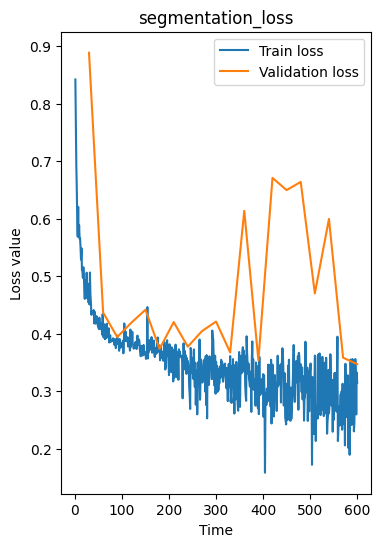

In [25]:
net_1.plot_train_loss()

In [27]:
result = net_1.test(test_loader)
print(f"Dice score on test set: {1-result}")
for i in range(3):
    print(f"Label {labels_dict[str(i)]}: Dice score: {1-torch.tensor(net_1.calculated_metrics[i]).mean()}")

Segmentation loss 0.347
Dice score on test set: 0.6528035700321198
Label background: Dice score: 0.9799927473068237
Label liver: Dice score: 0.6247903108596802
Label cancer: Dice score: 0.030593156814575195


## Visualize the segmentation and calculate class specific metrics

21 43 60
tensor(0)
Predicted labels
21 43 60


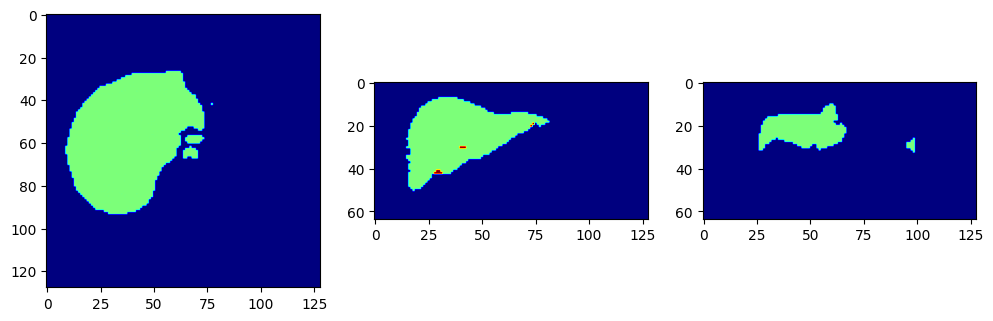

Real labels
21 43 60


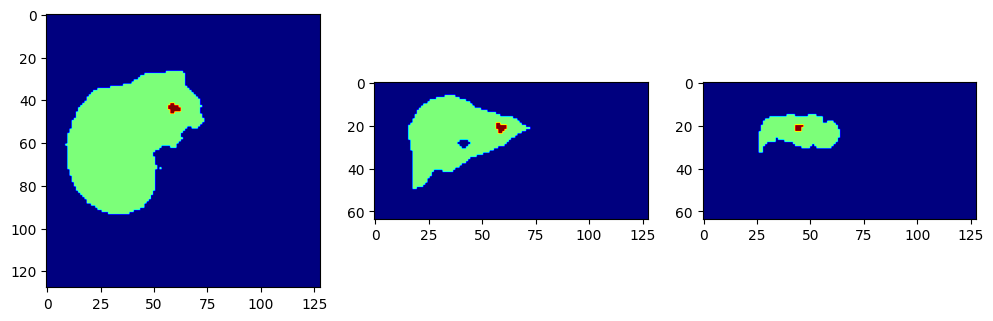

Real images
21 43 60


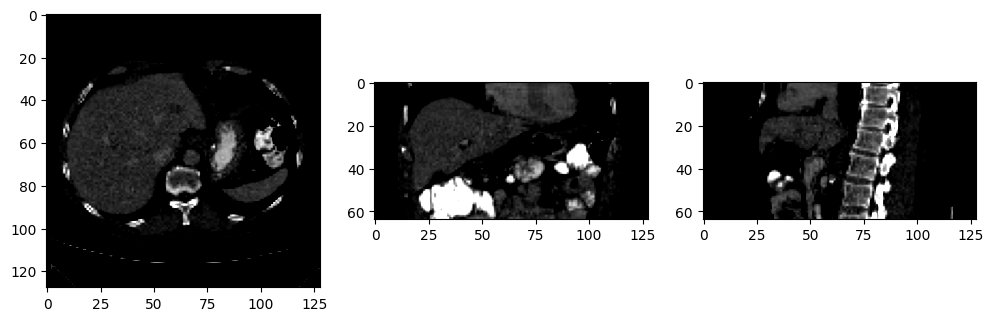

In [43]:
input, output = test_dataset[0]
d, h, w = get_index_around_tumour(output)
input = input.unsqueeze(0)
output = output.unsqueeze(0)
unet_model_1.eval()
# Push data to GPU
input = input.to(device)
output = output.to(device)
# Forward
predicted_label_prop = unet_model_1(input)
predicted_label_index, predicted_label = predicted_label_prop.max(dim=1)
# self.segmentatiion_loss_function(result,F.one_hot(output, num_classes=self.num_class).permute(0,4,1,2,3))
print("Predicted labels")
plt_3D(predicted_label.detach().cpu(), d, h, w, cmap="jet", vmin=0, vmax=2)
print("Real labels")
plt_3D(output.detach().cpu(), d, h, w, cmap="jet", vmin=0, vmax=2)
print("Real images")
plt_3D(input.detach().cpu(), d, h, w, cmap="gray", vmin=0, vmax=2)
del input, output, predicted_label_index, predicted_label_prop, predicted_label, d, h, w

# **Part 3 - Adding augmentation**

In this section, I will add segmentation to improve the network.

## Augmentation techniques used: adding Noise and Contrast, Elastic Deformations

Elastic Deformations: Which is used to simulate the heterogeneity in human body. It has two parameters: num_controlpoints and sigma. The num_controlpoints defines how many rows and columns are used to build a grid, where each vertex on the grid is a control point. These control points are translated randomly following a gaussian distribution with a std of sigma).

Noise: Which is used to simulate the noise added during image acquisition and reconstruction. It also reduce the information in the image which would act as a regularization for the network. It has one parameter: noise_level. The function add gaussian noise following a gaussian distribution in each pixel. The noise_level is the std of the distribution (the intensity of noise the image have).

Contrast: Which is used to simulate the different in X-ray absorption. It has three parameters: central_value, contrast_random_level, and brightness_random_level. The pixel values transformation is defined as **new_pixel_value** = (**old_pixel_value**-**central_value**)\***contrast**+**brightness**+**central_value**. The contrast and brightness are sampled from a uniform distribution in \[-**contrast_random_level**, **contrast_random_level**], and \[-**brightness_random_level**, **brightness_random_level**].

## Elastic Deformation augmentation

In [16]:
# Get image to test augmentation technique
file_name = "labelsTr/liver_0.nii"
label_tensor = open_and_get_image_data(root_path, file_name)
d, h, w = get_index_around_tumour(label_tensor)
file_name = "imagesTr/liver_0.nii"
image_tensor = open_and_get_image_data(root_path, file_name)

In [17]:
# Add elastic deformation as augmentation
import SimpleITK as sitk

"""Credit: The code is adapted from my MSc course!"""
def create_elastic_deformation(image, num_controlpoints, sigma):
    """
    We need to parameterise our b-spline transform
    The transform will depend on such variables as image size and sigma
    Sigma modulates the strength of the transformation
    The number of control points controls the granularity of our transform
    """
    #Transform zero np.array to sitk image
    itkimg = sitk.GetImageFromArray(np.zeros(image.shape))
    #Get total number of mesh point
    trans_from_domain_mesh_size = [num_controlpoints] * itkimg.GetDimension()
    #Initiate a transformation
    bspline_transformation = sitk.BSplineTransformInitializer(itkimg, trans_from_domain_mesh_size)
    #Get the transform parameter and convert them to np array
    params = np.asarray(bspline_transformation.GetParameters(), dtype=float)
    #Add randomness to transformation and set them back to sitk space
    params = params + np.random.randn(params.shape[0]) * sigma
    bspline_transformation.SetParameters(tuple(params))
    return bspline_transformation

def apply_elastic_deformation(image, bspline_transform, interpolation=sitk.sitkBSpline):
    # We need to choose an interpolation method for our transformed image, let's just go with b-spline
    resampler = sitk.ResampleImageFilter()    
    resampler.SetInterpolator(interpolation)
    # Let's convert our image to an sitk image
    sitk_image = sitk.GetImageFromArray(image)
    # Specify the image to be transformed: This is the reference image
    resampler.SetReferenceImage(sitk_image)
    resampler.SetDefaultPixelValue(0)
#     # Initialise the transform
#     bspline_transform = create_elastic_deformation(image, num_controlpoints, sigma)
    # Set the transform in the initialiser
    resampler.SetTransform(bspline_transform)
    # Carry out the resampling according to the transform and the resampling method
    out_img_sitk = resampler.Execute(sitk_image)
    # Convert the image back into a python array
    out_img = sitk.GetArrayFromImage(out_img_sitk)
    return out_img.reshape(image.shape)

# Add elastic augmentation
"""This is my implementation"""
class elastic_deform:
    def __init__(self, num_controlpoints=128, sigma=1):
        """num_controlpoints: tell how detail the grids used for transformation
        sigma: intensity of transformation"""
        self.num_controlpoints=num_controlpoints
        self.sigma=sigma
    def generate_transform(self, image):
        self.bspline_transform=create_elastic_deformation(image, self.num_controlpoints, self.sigma)
    def apply_transform_on_image(self, image):
        return torch.from_numpy(apply_elastic_deformation(image, self.bspline_transform, interpolation=sitk.sitkBSpline))
    def apply_transform_on_label(self, image):
        return torch.from_numpy(apply_elastic_deformation(image, self.bspline_transform, interpolation=sitk.sitkNearestNeighbor))

torch.Size([32, 64, 64])
torch.Size([32, 64, 64])
15 328 194


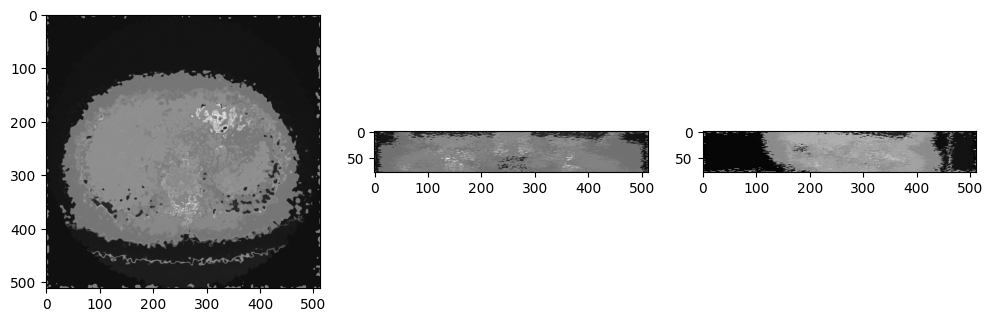

15 328 194


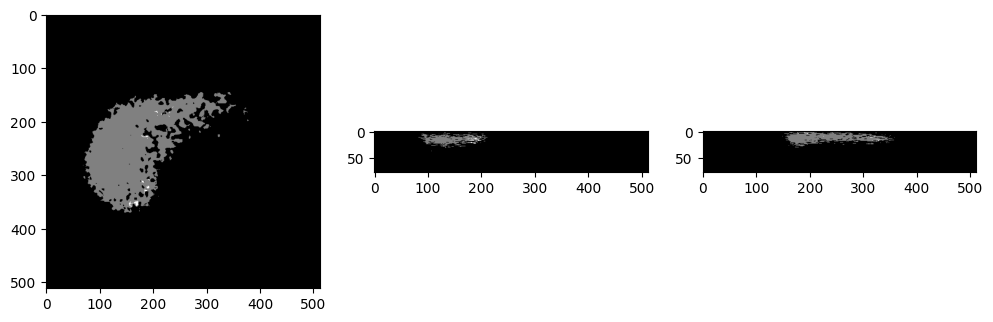

In [18]:
# Elastic deformation test
# Unit test
test_image_tensor = torch.rand(32, 64, 64)
test = elastic_deform(num_controlpoints=128, sigma=10)
test.generate_transform(test_image_tensor)
transformed_image=test.apply_transform_on_image(test_image_tensor)
transformed_label=test.apply_transform_on_label(test_image_tensor)
print(transformed_image.size())
print(transformed_label.size())
del test, transformed_image, transformed_label

# Unit test on image
test = elastic_deform(num_controlpoints=128, sigma=10)
test.generate_transform(image_tensor)
transformed_image=test.apply_transform_on_image(image_tensor)
transformed_label=test.apply_transform_on_label(label_tensor)
plt_3D(transformed_image, d, h, w)
plt_3D(transformed_label, d, h, w)
del test, transformed_image, transformed_label

## Noise and contrast augmentation

37 256 256


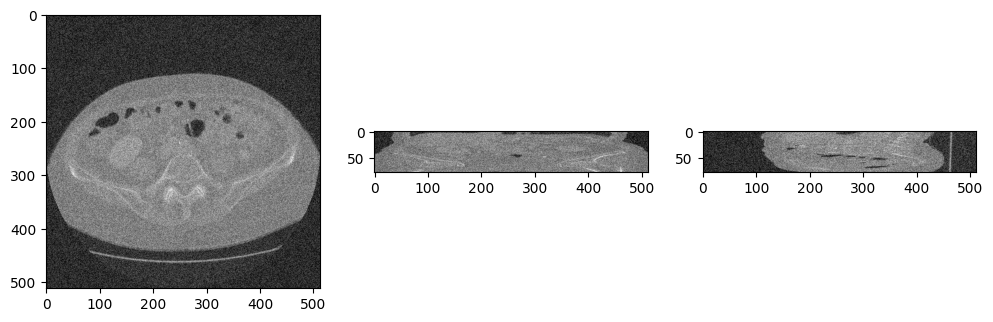

Original min -1024.0
After contrast augmentation min -785.4292938232422
Original mean -523.4203318277995
After contrast augmentation mean -432.4490599542892
37 256 256


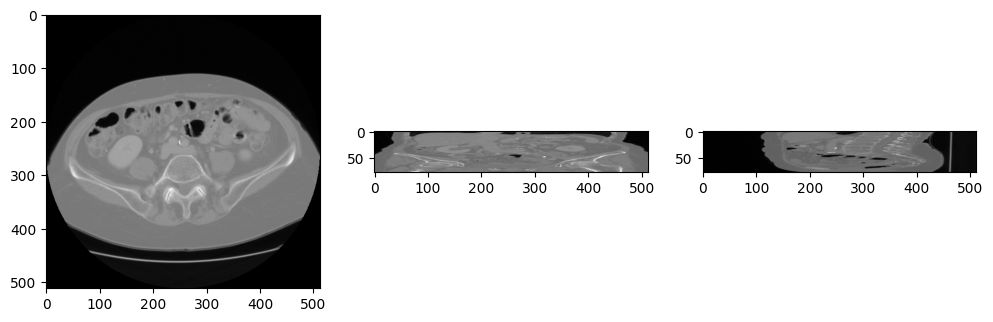

In [19]:
# Add noise augmentation
class add_noise:
    def __init__(self, noise_level=1.0):
        self.noise_level=noise_level
    def __call__(self, image):
        return image + torch.rand_like(image)*self.noise_level
x = image_tensor
test = add_noise(1000.0)
plt_3D(test(x))

# Add contrast augmentation
class add_contrast:
    def __init__(self, central_value=0.0, contrast_random_level=0.0, brightness_random_level=0.0):
        self.central_value=central_value
        self.contrast_random_level=contrast_random_level
        self.brightness_random_level=brightness_random_level
    def __call__(self, image):
        contrast = 1 + (torch.rand(1).item()*2-1)*self.contrast_random_level
        brightness = (torch.rand(1).item()*2-1)*self.brightness_random_level
        return (image-self.central_value)*contrast + brightness + self.central_value
x = image_tensor
test = add_contrast(0, 0.2, 400)
print(f"Original min {x.min()}")
print(f"After contrast augmentation min {test(x).min()}")
print(f"Original mean {x.mean()}")
print(f"After contrast augmentation mean {test(x).mean()}")
plt_3D(test(x))

In [21]:
# Loop through 20 images to get the std of mean and std of std for contrast augmentation
# This takes a lot of time, which is why it is cmt out
# image_stack = []
mean_stack = []
std_stack = []
for i in range(20):
    # open the image
    file_name = f"imagesTr/liver_{i}.nii"
    image = image_transform(open_and_get_image_data(root_path, file_name))
    mean_stack.append(image.mean().item())
    std_stack.append(image.std().item())
    del image
std_stack = torch.tensor(std_stack)
mean_stack = torch.tensor(mean_stack)
contrast_random_level = (std_stack.std()/std_stack.mean().abs()).item()
brightness_random_level = mean_stack.std().item()
print(f"Contrast random level {contrast_random_level}")
print(f"Brightness random level {brightness_random_level}")
contrast_random_level = 0.1996201127767563
brightness_random_level = 0.7545859813690186
print(f"Contrast random level {contrast_random_level}") 
print(f"Brightness random level {brightness_random_level}")

Contrast random level 0.1996201127767563
Brightness random level 0.7545859813690186


## Create dataloader with augmentation

Execute time: 5.190668369000036
32 64 64


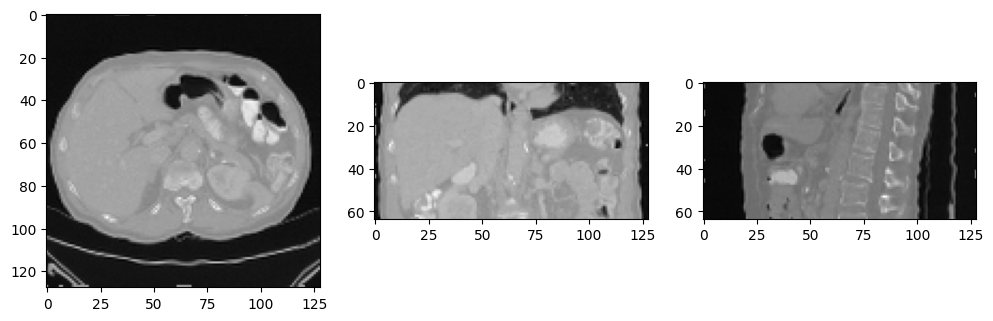

32 64 64


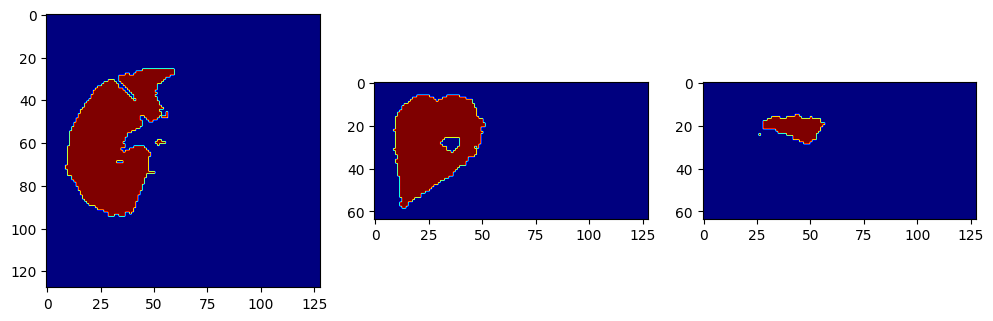

Min -5.369999885559082 -> -6.873918056488037
Max 5.695937633514404 -> 5.5907135009765625
Mean -2.4269614219665527 -> -3.128103494644165
Std 2.5573182106018066 -> 2.6150171756744385


In [22]:
from torchvision.transforms import Compose, Normalize
# Define the transformation
output_size=(64, 128, 128)
image_transform = Compose([
    Normalize(mean=image_mean, std=image_std),
])
image_augmentation_transform = Compose([
    add_noise(noise_level=0.1),
    add_contrast(contrast_random_level=contrast_random_level,
                 brightness_random_level=brightness_random_level)
])
both_augmentation_transform = elastic_deform(num_controlpoints=64//2, sigma=1)

# Create dataset
train_dataset_augmented = liver_image_dataset(data_dict, train_idx, image_transform=image_transform,
                                              image_augmentation_transform=image_augmentation_transform,
                                              both_augmentation_transform=both_augmentation_transform,
                                              output_size=output_size)

# Test
start_time = time.perf_counter()
test_data = train_dataset_augmented[0]
test_data_raw = train_dataset_raw[0]
print(f"Execute time: {time.perf_counter()-start_time}")
plt_3D(test_data[0], cmap = "gray")
plt_3D(test_data[1], cmap = "jet")
print(f"Min {test_data_raw[0].min()} -> {test_data[0].min()}")
print(f"Max {test_data_raw[0].max()} -> {test_data[0].max()}")
print(f"Mean {test_data_raw[0].mean()} -> {test_data[0].mean()}")
print(f"Std {test_data_raw[0].std()} -> {test_data[0].std()}")
del test_data

## Training the network with augmentation

In [17]:
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Memory allocated: 0.00 MB


In [23]:
# Model
depth=4
in_channels=1
complexity=64
num_class=3
unet_model_2 = My3DUNet_1(depth=depth, in_channels=in_channels, complexity=complexity, num_class=num_class)
total_params = sum(p.numel() for p in unet_model_2.parameters())
print(f"Total number of parameters: {total_params}")
# Optimizer
beta1 = 0.9
beta2 = 0.999
lr = 0.001
optimizer = optim.Adam(unet_model_2.parameters(), lr=lr, betas=(beta1, beta2))
# Loss function
segmentation_loss_function = dice_loss
# Model wrapper
save_file = os.path.join(root_path,'unet_2_parameters.pth')
save_file = os.path.join('/kaggle/working','unet_2_parameters.pth')

net_2 = Unet_Model_Wrapper(unet_model_2, optimizer, segmentation_loss_function, device, save_file)
net_2.push_to_device()
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Total number of parameters: 90298691
Using 2 GPUs!
Memory allocated: 347.52 MB


In [25]:
# Change the batch size and number of worker if needed (To avoid overflow and speed up training)
batch_size = 4
num_workers = 8 #8 Worker allow the network not to wait for CPU to load data
train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Loader: train size {len(train_loader_raw)}, validation size {len(val_loader)}, test size {len(test_loader)}")

Loader: train size 29, validation size 2, test size 2


In [33]:
current_number_of_epochs = 0
min_loss = 1000

In [34]:
total_number_of_epochs = 20
while current_number_of_epochs < total_number_of_epochs:
    train_loss = net_2.train(train_loader_augmented)
    val_loss = net_2.val(val_loader)
    # Early stopping to avoid overfitting
    if val_loss < min_loss:
        min_loss = val_loss
        net_2.save_model()        
    current_number_of_epochs+=1
    print(f"Epoch {current_number_of_epochs}/{total_number_of_epochs}: train loss {train_loss}; val loss: {val_loss}")
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Segmentation loss: Train 0.397; Val 0.403
Epoch 1/20: train loss 0.4067704379558563; val loss: 0.40264391899108887
Segmentation loss: Train 0.387; Val 0.522
Epoch 2/20: train loss 0.3910188674926758; val loss: 0.5218579769134521
Segmentation loss: Train 0.382; Val 0.4
Epoch 3/20: train loss 0.39111560583114624; val loss: 0.39978668093681335
Segmentation loss: Train 0.381; Val 0.394
Epoch 4/20: train loss 0.38640350103378296; val loss: 0.39362984895706177
Segmentation loss: Train 0.367; Val 0.382
Epoch 5/20: train loss 0.37960684299468994; val loss: 0.38246968388557434
Segmentation loss: Train 0.354; Val 0.401
Epoch 6/20: train loss 0.37779033184051514; val loss: 0.40116816759109497
Segmentation loss: Train 0.394; Val 0.501
Epoch 7/20: train loss 0.3992597460746765; val loss: 0.501420259475708
Segmentation loss: Train 0.388; Val 0.403
Epoch 8/20: train loss 0.3873710632324219; val loss: 0.4032941460609436
Segmentation loss: Train 0.387; Val 0.412
Epoch 9/20: train loss 0.383255392313003

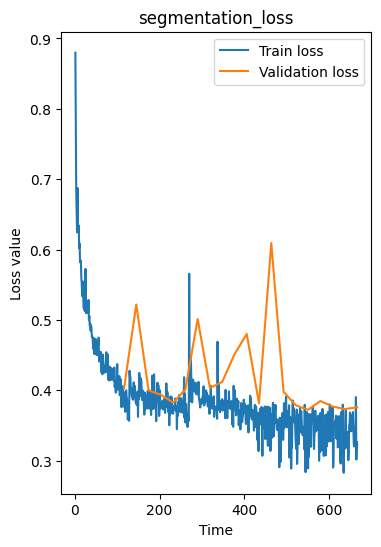

In [35]:
net_2.plot_train_loss()

In [36]:
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Memory allocated: 1384.42 MB


In [37]:
result = net_2.test(test_loader)
print(f"Dice score on test set: {1-result}")
for i in range(3):
    print(f"Label {labels_dict[str(i)]}: Dice score: {1-torch.tensor(net_2.calculated_metrics[i]).mean()}")


Segmentation loss 0.376
Dice score on test set: 0.6241264939308167
Label background: Dice score: 0.9796692728996277
Label liver: Dice score: 0.597620964050293
Label cancer: Dice score: 0.012839317321777344


## Visualizing the results

Predicted labels
21 43 60


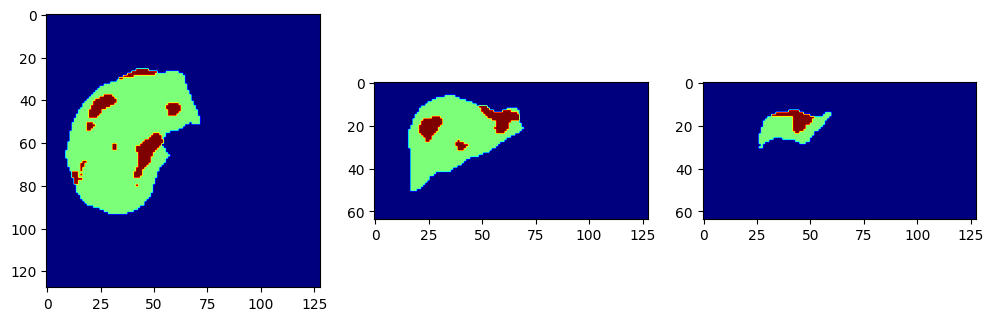

Real labels
21 43 60


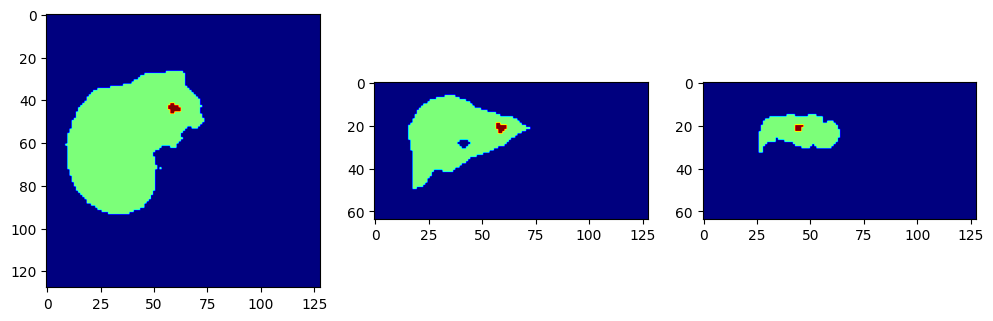

Real images
21 43 60


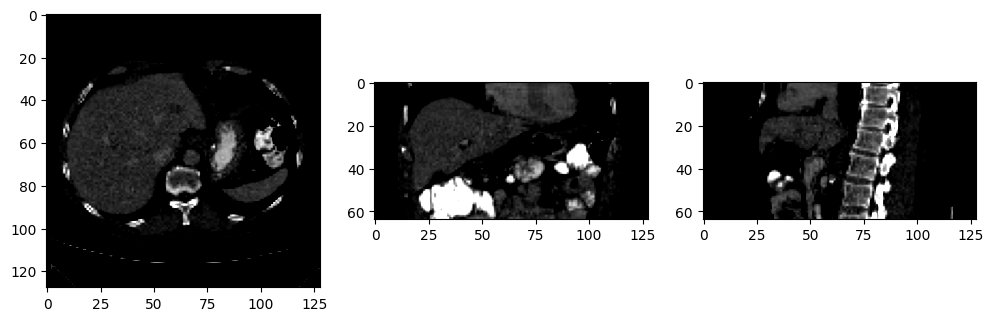

In [38]:
input, output = test_dataset[0]
d, h, w = get_index_around_tumour(output)
input = input.unsqueeze(0)
output = output.unsqueeze(0)
unet_model_2.eval()
# Push data to GPU
input = input.to(device)
output = output.to(device)
# Forward
predicted_label_prop = unet_model_2(input)
predicted_label_index, predicted_label = predicted_label_prop.max(dim=1)
# self.segmentatiion_loss_function(result,F.one_hot(output, num_classes=self.num_class).permute(0,4,1,2,3))
print("Predicted labels")
plt_3D(predicted_label.detach().cpu(), d, h, w, cmap="jet", vmin=0, vmax=2)
print("Real labels")
plt_3D(output.detach().cpu(), d, h, w, cmap="jet", vmin=0, vmax=2)
print("Real images")
plt_3D(input.detach().cpu(), d, h, w, cmap="gray", vmin=0, vmax=2)
del input, output, predicted_label_index, predicted_label_prop, predicted_label, d, h, w


## Comment:
### Adding augmentation significantly reduce the gap between training and validation loss because augmentation help the network exposed to more samples. Some augmentation obscure some of the input information, which also act as a regularization method.


# **Part 4 - Modification to the Loss to handle data imbalance**
The tumor (class 2) account for a very small percentage of the volumes, making its segmentation challenging. I will change modify the Dice Loss to tackle the imbalance in data.

## Define some other loss functions that I will test, trying to improve the network

In [26]:
class FocalLoss(nn.Module): 
    def __init__(self, gamma=2.):
        """https://towardsdatascience.com/focal-loss-a-better-alternative-for-cross-entropy-1d073d92d075
        My implemetation of focal lost
        It take in probability (after softmax) and labels (after one hot encoded)
        And return the loss"""
        super().__init__()
        self.gamma = gamma
        self.eps = 1e-6
        
    def forward(self, input_tensor, target_tensor):
        input_tensor = torch.clamp(input_tensor, self.eps, 1. - self.eps)
        result = -((1-input_tensor)**self.gamma)*torch.log(input_tensor)*target_tensor
        result = result.mean(dim=(2,3,4))
        return result.mean()

test = FocalLoss(2.0)
x = torch.rand(1,3,64,128,128)
# print(x.max())
y = torch.randint(0, 2, size=(1,3,64,128,128), dtype=torch.long)
y2 = y.to(torch.float)
print(test(x,y))
print(test(y2,(1-y)))
print(test(y2,y))

tensor(0.3045)
tensor(6.9154)
tensor(5.1961e-19)


In [27]:
# Define loss function
# Loss function: My dice loss
def dice_loss_weighted_TP_TN(prediction, truth, alpha=0.5):
    """Calculate 1 - generalized_dice_score
    The truth need to be one-hot encoded"""
    assert truth.max()<=1, "The truth need to be one-hot encoded"
    assert truth.min()>=0, "The truth need to be one-hot encoded"
    epsilon=1e-6
    total_dim = truth.dim() #Dimension of input (4 for 2D image and 5 for 3D)
    # Calculate the loss
    numerator_TP = torch.mean(truth*prediction, dim = tuple(range(2,total_dim)))
    denominator_TP = torch.mean((truth**2+prediction**2), dim = tuple(range(2,total_dim)))
    numerator_TN = torch.mean((1-truth)*(1-prediction), dim = tuple(range(2,total_dim)))
    denominator_TN = torch.mean(((1-truth)**2+(1-prediction)**2), dim = tuple(range(2,total_dim)))
    dice = alpha*2*(numerator_TP+epsilon) / (denominator_TP+epsilon) + (1-alpha)*2*(numerator_TN+epsilon) / (denominator_TN+epsilon)
    dice = dice.mean(dim=1)
    return 1-dice.mean()
alpha = 0.2
x = torch.rand(1,3,64,64,64)
y = torch.randint(0, 2, size=(1,3,64,64,64), dtype=torch.long)
y2 = y.to(torch.float)
print(dice_loss_weighted_TP_TN(x,y,alpha))
print(dice_loss_weighted_TP_TN(y2,(1-y),alpha))
print(dice_loss_weighted_TP_TN(y2,y,alpha))

tensor(0.4002)
tensor(1.0000)
tensor(-9.5367e-07)


In [28]:
class FocalDiceLoss(nn.Module): 
    def __init__(self, weights=[1.0,1.0,1.0], gamma=2., alpha=0.5):
        """Calculate dice loss but combine with the focal
        loss for adaptive weighting of hard to predict labels
        weights: the weight for each class
        gamma: use in focal loss (1-p)**gamma to balance between classes
        alpha: weight for TP and TN dice coefficient
        """
        super().__init__()
        assert alpha>=0.0 and alpha<=1.0, "alpha need to be within [0,1]"
        self.gamma = gamma
        self.weights = nn.Parameter(torch.tensor(weights).view(-1,3), requires_grad=False)        
        self.alpha = alpha
        self.eps = 1e-6
        
    def forward(self, input_tensor, target_tensor):
        assert target_tensor.max()<=1, "The truth need to be one-hot encoded"
        assert target_tensor.min()>=0, "The truth need to be one-hot encoded"
        total_dim = target_tensor.dim() #Dimension of input (4 for 2D image and 5 for 3D)
        # Calculate the dice loss for TP and TN
        numerator_TP = torch.mean(input_tensor*target_tensor, dim = tuple(range(2,total_dim)))
        denominator_TP = torch.mean((input_tensor**2+target_tensor**2), dim = tuple(range(2,total_dim)))
        numerator_TN = torch.mean((1-input_tensor)*(1-target_tensor), dim = tuple(range(2,total_dim)))
        denominator_TN = torch.mean(((1-input_tensor)**2+(1-target_tensor)**2), dim = tuple(range(2,total_dim)))
        dice = self.alpha*2*(numerator_TP+self.eps) / (denominator_TP+self.eps) + (1-self.alpha)*2*(numerator_TN+self.eps) / (denominator_TN+self.eps)
        # Use the focal loss formula to weight the dice coefficient and multiply it with custom weights by user
        result = -((1-dice)**self.gamma)*torch.log(dice)
        result = result*self.weights
        return result.mean()

test = FocalDiceLoss(weights=[1,2,3], gamma=2.0, alpha=0.5)
x = torch.rand(1,3,64,128,128)
# print(x.max())
y = torch.randint(0, 2, size=(1,3,64,128,128), dtype=torch.long)
y2 = y.to(torch.float)
print(test(x,y))
print(test(y2,(1-y)))
print(test(y2,y))

tensor(0.1629)
tensor(26.2446)
tensor(-2.4699e-18)


In [29]:
# Define loss function
# Loss function: My dice loss
def dice_loss_modified(prediction, truth):
    """Calculate 1 - generalized_dice_score
    The truth need to be one-hot encoded"""
    assert truth.max()<=1, "The truth need to be one-hot encoded"
    assert truth.min()>=0, "The truth need to be one-hot encoded"
    total_dim = truth.dim() #Dimension of input (4 for 2D image and 5 for 3D)
    # Count the number of class and get the weights
    # Calculate the loss
    prediction_modified = torch.where(prediction>=0.9, torch.tensor(1.0), prediction)
    prediction_modified = torch.where(prediction_modified<=0.1, torch.tensor(0.0), prediction_modified)
    numerator = torch.sum(truth*prediction_modified, dim = tuple(range(2,total_dim)))
    denominator = torch.sum((truth**2+prediction_modified**2), dim = tuple(range(2,total_dim)))
    dice = torch.where(denominator!=0,2* (numerator) / (denominator),denominator)
    dice = dice.mean(dim=1)
    return 1-dice.mean()
x = torch.rand(7,5,64,64,64)
y = torch.randint(0, 2, size=(7,5,64,64,64), dtype=torch.long)
y2 = y.to(torch.float)
print(dice_loss_modified(x,y))
print(dice_loss_modified(y2,(1-y)))
print(dice_loss_modified(y2,y))

tensor(0.4066)
tensor(1.)
tensor(0.)


In [30]:
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Memory allocated: 347.52 MB


## Training and testing the network

In [31]:
# Model
depth=4
in_channels=1
complexity=64
num_class=3
unet_model_3 = My3DUNet_1(depth=depth, in_channels=in_channels, complexity=complexity, num_class=num_class)
total_params = sum(p.numel() for p in unet_model_3.parameters())
print(f"Total number of parameters: {total_params}")
# Optimizer
beta1 = 0.9
beta2 = 0.999
lr = 0.001
optimizer = optim.Adam(unet_model_3.parameters(), lr=lr, betas=(beta1, beta2))
# Loss function
segmentation_loss_function = FocalDiceLoss(weights = [1.0, 1.0, 1.0], gamma=2.0, alpha=1.0).to(device)
# Model wrapper
save_file = os.path.join(root_path,'unet_3_parameters.pth')
save_file = os.path.join('/kaggle/working','unet_3_parameters.pth')


net_3 = Unet_Model_Wrapper(unet_model_3, optimizer, segmentation_loss_function, device, save_file)
net_3.push_to_device()
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Total number of parameters: 90298691
Using 2 GPUs!
Memory allocated: 692.04 MB


In [32]:
# Change the batch size and number of worker if needed (To avoid overflow and speed up training)
batch_size = 4
num_workers = 8 #8 Worker allow the network not to wait for CPU to load data
train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Loader: train size {len(train_loader_raw)}, validation size {len(val_loader)}, test size {len(test_loader)}")

Loader: train size 29, validation size 2, test size 2


## Because the network is fully convolutional, therefore, it is spatial invariant and training it on a crop version is expected to produce the same result as the original version.

Test: 6
Execute time: 4.459671073999971
17 48 55


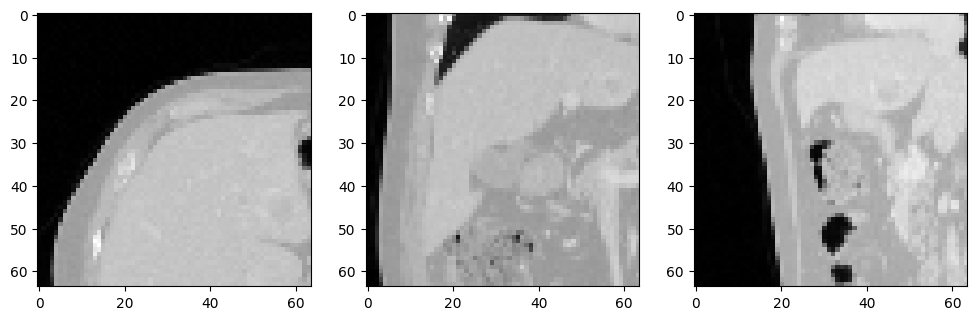

17 48 55


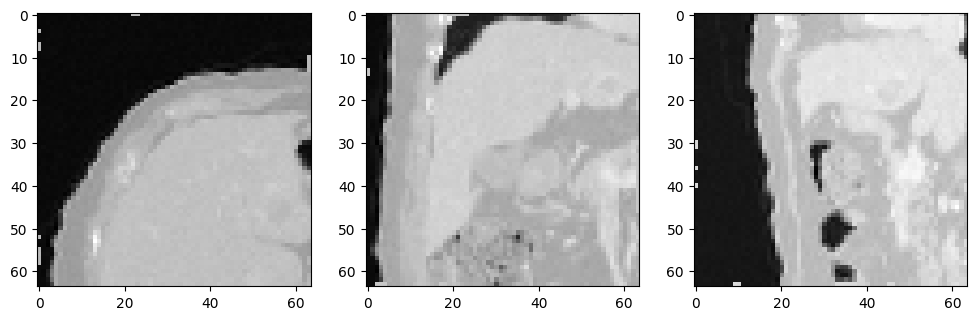

17 48 55


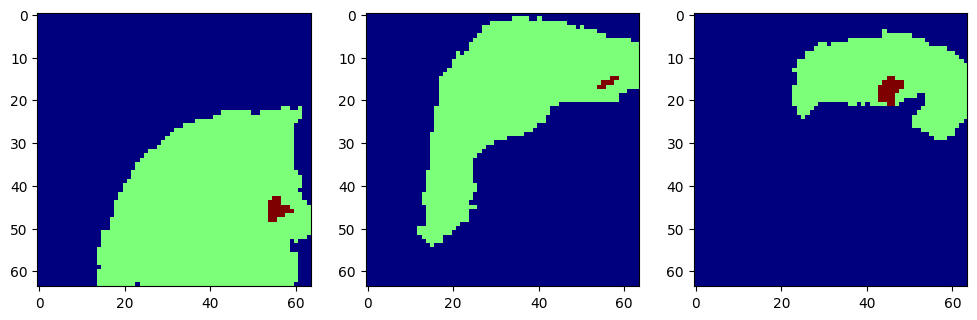

torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])


In [33]:
# CREATE A SMALLER DATASET AND DATALOADERS
# The tissue window of CT image is from -150 to 250
image_mean=50.0
image_std=200.0

# Define the full transform
image_transform = Compose([
    Normalize(mean=image_mean, std=image_std),
])
image_augmentation_transform = Compose([
    add_noise(noise_level=0.1),
    add_contrast(contrast_random_level=contrast_random_level,
                 brightness_random_level=brightness_random_level)
])
both_augmentation_transform = elastic_deform(num_controlpoints=64//2, sigma=1)

class liver_image_dataset_small(Dataset):
    def __init__(self, data_dict, data_idx, image_transform=None,
                 image_augmentation_transform=None, both_augmentation_transform=None,
                 output_size=(64, 128, 128)):
        # Store meta data and path
        self.data_dict=data_dict
        self.data_idx=data_idx
        self.image_transform=image_transform
        self.image_augmentation_transform=image_augmentation_transform
        self.both_augmentation_transform=both_augmentation_transform       
        self.output_size = output_size
        # Check the data dict contain all data_idx. And data path contain all file in data_dict
        for idx in data_idx:
            try:
                assert os.path.exists(data_dict[idx]["image"]), "Cannot find image"
                assert os.path.exists(data_dict[idx]["label"]), "Cannot find label"                
            except IndexError:
                assert False, "One of data_idx is not available in data_dict"        
    def __len__(self):
        # Return length of datasetss
        return len(self.data_idx)
    def __getitem__(self, index):
        # Go into the folder with file name and read data
        image = open_and_get_image_data("/", self.data_dict[index]["image"])
        label = open_and_get_image_data("/", self.data_dict[index]["label"])
        # Transformation of data
        if self.image_transform:
            image = self.image_transform(image)
        # Get the windows with only liver
        depth = image.size(0)
        non_zero_index = torch.nonzero(label)
        depth_max = non_zero_index[:,0].max().item() + int(depth/50)
        depth_min = non_zero_index[:,0].min().item() - int(depth/50)
        depth_max = min(depth_max, depth)
        depth_min = max(depth_min, 0)
        image = image[depth_min:depth_max,:,:]
        label = label[depth_min:depth_max,:,:]        
        # Resize all images into 1 desired size(256, 512, 512)
        image = image.unsqueeze(0).unsqueeze(0)
        label = label.unsqueeze(0).unsqueeze(0)
        image = F.interpolate(image, size=self.output_size, mode='trilinear', align_corners=False)
        label = F.interpolate(label, size=self.output_size, mode='nearest')
        image = image.squeeze()
        label = label.squeeze()        
        # Crop the image where the tumor start
        tumor_index = torch.nonzero(label==2)
        if len(tumor_index>0):
            height_min = min(max(tumor_index[:,1].min().item()-4,0),64)
            width_min = min(max(tumor_index[:,2].min().item()-4,0),64)
            image = image[:,height_min:height_min+64,width_min:width_min+64]
            label = label[:,height_min:height_min+64,width_min:width_min+64]
        else:
            image = image[:,64:64+64,64:64+64]
            label = label[:,64:64+64,64:64+64]            
        # MAKE SURE THE AUGMENTATION IS IMPLEMENTED AFTER image_transform WHICH IS STANDARD TRANSFORM
        if self.both_augmentation_transform:
            self.both_augmentation_transform.generate_transform(image)
            image=self.both_augmentation_transform.apply_transform_on_image(image)
            label=self.both_augmentation_transform.apply_transform_on_label(label)
        if self.image_augmentation_transform:
            image = self.image_augmentation_transform(image)
        image = image.unsqueeze(0)
        # Convert data to desired type
        image = image.to(torch.float)
        label = label.to(torch.long)
        return image, label

# Test
test = liver_image_dataset(data_dict, val_idx)
print(f"Test: {len(test)}")

# Create dataset
train_dataset_raw_small = liver_image_dataset_small(data_dict, train_idx, image_transform=image_transform,
                                                    image_augmentation_transform=None, both_augmentation_transform=None,
                                                    output_size=output_size)
train_dataset_augmented_small = liver_image_dataset_small(data_dict, train_idx, image_transform=image_transform,
                                                          image_augmentation_transform=image_augmentation_transform,
                                                          both_augmentation_transform=both_augmentation_transform,
                                                          output_size=output_size)
batch_size=4
num_workers=8
train_loader_raw_small = DataLoader(train_dataset_raw_small, batch_size=batch_size*4, shuffle=True, num_workers=num_workers, drop_last=True)
train_loader_augmented_small = DataLoader(train_dataset_augmented_small, batch_size=batch_size*4, shuffle=True, num_workers=num_workers, drop_last=True)

# Test
start_time = time.perf_counter()
test_data = train_dataset_augmented_small[1]
test_data_raw = train_dataset_raw_small[1]
print(f"Execute time: {time.perf_counter()-start_time}")
d, h, w = get_index_around_tumour(test_data[1])
plt_3D(test_data_raw[0], d, h, w, cmap = "gray")
plt_3D(test_data[0], d, h, w, cmap = "gray")
plt_3D(test_data[1], d, h, w, cmap = "jet")
print(test_data[0].size())
print(test_data[1].size())

## Load model from previous training

In [41]:
# Load previous training
model_root_path = '/kaggle/input/unet_model/pytorch/v8/1'
# Call the function to list the folder tree
list_current_folder_tree(model_root_path)
# net_3.model.load_state_dict(torch.load(os.path.join(model_root_path, "unet_3_parameters_end.pth")))
import pickle
with open(os.path.join(model_root_path, "model_wrapper.pkl"), 'rb') as f:
    load_wrapper = pickle.load(f)

net_3.model = load_wrapper.model
net_3.optimizer = load_wrapper.optimizer
net_3.total_train_epoch = load_wrapper.total_train_epoch
net_3.total_val_epoch = load_wrapper.total_val_epoch
net_3.loss_list = load_wrapper.loss_list
net_3.calculated_metrics = load_wrapper.calculated_metrics

net_3.push_to_device()

📄 model_wrapper.pkl
Using 2 GPUs!


In [35]:
# Change between the loss to see if the network can be improved further
net_3.segmentation_loss_function = FocalDiceLoss(weights = [0.1, 1.0, 1.0], gamma=2.0, alpha=1.0).to(device)
net_3.segmentation_loss_function = dice_loss
net_3.segmentation_loss_function = dice_loss_modified

In [28]:
current_number_of_epochs = 0
min_loss = 1000

## Continue to train the model

In [37]:
current_number_of_epochs = 110
total_number_of_epochs = 111
min_loss = 1000
while current_number_of_epochs < total_number_of_epochs:
    train_loss = net_3.train(train_loader_augmented)
#     train_loss = net_3.train(train_loader_raw)
#     train_loss = net_3.train(train_loader_raw_small)
#     train_loss = net_3.train(train_loader_augmented_small)
    val_loss = net_3.val(val_loader)
    for i in range(3):
        print(f"{labels_dict[str(i)]}: Dice score: {round(1-torch.tensor(net_3.calculated_metrics[i]).mean().item(),3)}", end="; ")
    print()
    # Early stopping to avoid overfitting
    if val_loss < min_loss:
        min_loss = val_loss
        net_3.save_model()        
    current_number_of_epochs+=1
    print(f"Epoch {current_number_of_epochs}/{total_number_of_epochs}: train loss {train_loss}; val loss: {val_loss}")
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Segmentation loss: Train 0.131; Val 0.222
background: Dice score: 0.975; liver: Dice score: 0.573; cancer: Dice score: 0.09; 
Epoch 111/111: train loss 0.20522084832191467; val loss: 0.22151005268096924
Memory allocated: 2071.11 MB


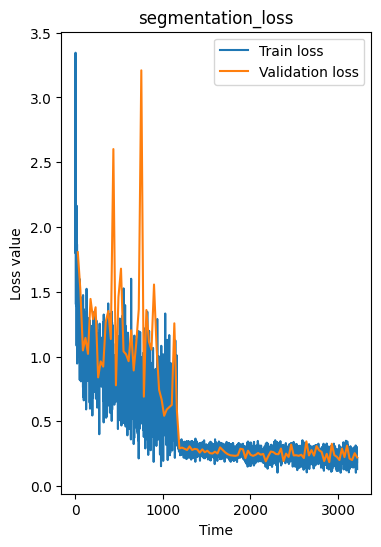

In [38]:
net_3.plot_train_loss()

In [39]:
result = net_3.test(test_loader)
print(f"Dice loss on test set: {result}")
for i in range(3):
    print(f"Label {labels_dict[str(i)]}: Dice score: {1-torch.tensor(net_3.calculated_metrics[i]).mean()}")
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Segmentation loss 0.222
Dice loss on test set: 0.22151005268096924
Label background: Dice score: 0.9752712249755859
Label liver: Dice score: 0.5730161666870117
Label cancer: Dice score: 0.0901075005531311
Memory allocated: 2071.11 MB


Predicted labels
21 43 60


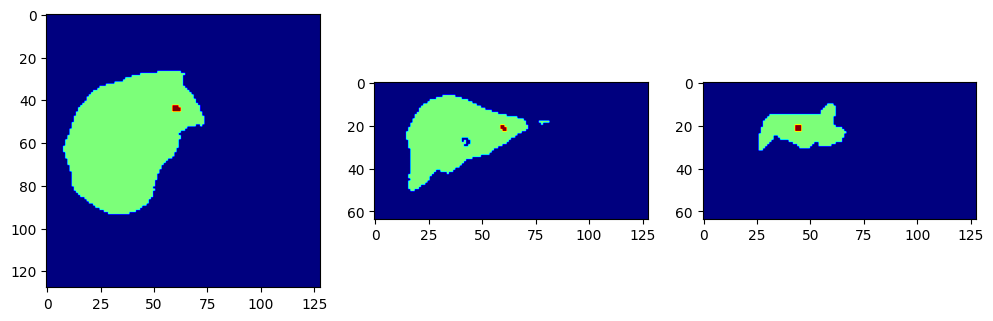

Real labels
21 43 60


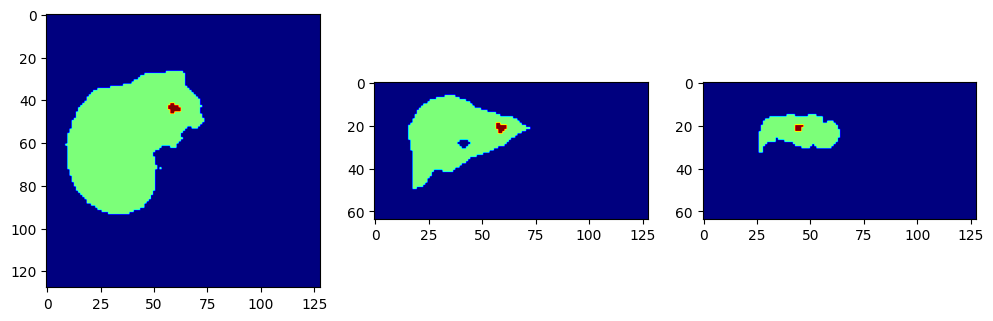

Real images
21 43 60


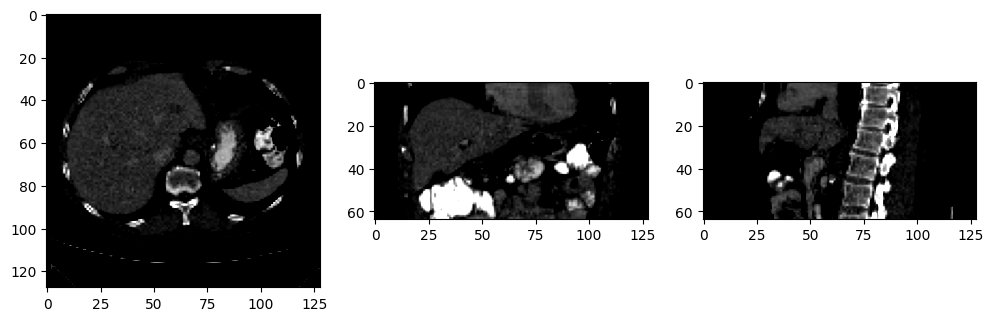

Memory allocated: 1726.91 MB


In [42]:
input, output = test_dataset[0]
d, h, w = get_index_around_tumour(output)
input = input.unsqueeze(0)
output = output.unsqueeze(0)
unet_model_3.eval()
# Push data to GPU
input = input.to(device)
output = output.to(device)
# Forward
predicted_label_prop = net_3.model(input)
predicted_label_index, predicted_label = predicted_label_prop.max(dim=1)
# d, h, w = get_index_around_tumour(predicted_label)
# self.segmentatiion_loss_function(result,F.one_hot(output, num_classes=self.num_class).permute(0,4,1,2,3))
print("Predicted labels")
plt_3D(predicted_label.detach().cpu(), d, h, w, cmap="jet", vmin=0, vmax=2)
print("Real labels")
plt_3D(output.detach().cpu(), d, h, w, cmap="jet", vmin=0, vmax=2)
print("Real images")
plt_3D(input.detach().cpu(), d, h, w, cmap="gray", vmin=0, vmax=2)
del input, output, predicted_label_index, predicted_label_prop, predicted_label, d, h, w
print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

## Use Hausdorff distance as a metric for validation

In [43]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.spatial.distance import directed_hausdorff


def extract_border(label_map):
    dilated = binary_dilation(label_map)
    eroded = binary_erosion(label_map)
    border = dilated ^ eroded  # XOR operation
    return np.array(np.where(border)).T

def hausdorff_distance_3d(pred, gt):
    # Extract borders
    border1 = extract_border(pred)
    border2 = extract_border(gt)
    # Compute Hausdorff distance
    return directed_hausdorff(border1, border2)[0]

pred = np.array([[[0, 0, 0],
                  [0, 1, 0],
                  [0, 0, 0]],
                 [[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]],
                 [[0, 0, 0],
                  [0, 1, 0],
                  [0, 0, 0]]])

gt = np.array([[[0, 0, 0],
                [0, 1, 0],
                [0, 0, 0]],
               [[0, 1, 0],
                [1, 1, 1],
                [0, 1, 0]],
               [[0, 0, 0],
                [0, 1, 0],
                [0, 0, 0]]])

print(f"Directed Hausdorff distance: {hausdorff_distance_3d(pred,gt)}")

Directed Hausdorff distance: 0.0


In [44]:
# Loop throught test set and calculate the hausdorff distance
net_3.model.eval()
hausdorff_distance_background = []
hausdorff_distance_liver = []
hausdorff_distance_cancer = []
for i in range(len(test_dataset)):
    input, output = test_dataset[i]
    input = input.unsqueeze(0).to(device)
    output = output.squeeze().numpy()
    predicted_label_prop = net_3.model(input)
    predicted_label_index, predicted_label_cuda = predicted_label_prop.max(dim=1)
    predicted_label = predicted_label_cuda.squeeze().cpu().detach().numpy()
    hausdorff_distance_background.append(hausdorff_distance_3d(predicted_label==0, output==0))
    hausdorff_distance_liver.append(hausdorff_distance_3d(predicted_label==1, output==1))
    hausdorff_distance_cancer.append(hausdorff_distance_3d(predicted_label==2, output==2))  
    print(f"Memory allocated: {torch.cuda.memory_allocated(device) / (1024 ** 2):.2f} MB")

Memory allocated: 5287.41 MB
Memory allocated: 5286.41 MB
Memory allocated: 5288.09 MB
Memory allocated: 5286.41 MB
Memory allocated: 5287.41 MB
Memory allocated: 5286.41 MB


In [45]:
print(f"Hausdorff Distance for background {torch.mean(torch.tensor(hausdorff_distance_background))}")
print(f"Hausdorff Distance for liver {torch.mean(torch.tensor(hausdorff_distance_liver))}")
print(f"Hausdorff Distance for liver cancer {torch.mean(torch.tensor(hausdorff_distance_cancer))}")

Hausdorff Distance for background 11.658366203308105
Hausdorff Distance for liver 17.603212356567383
Hausdorff Distance for liver cancer 7.389009475708008


# **Part 5 - Stored codes**

This section stores some code that is too trivial or too bulky to be in the main part.

They are stored as I might use them later.

## Testing network capacity by ovetfitting it with 1 sample

In [62]:
# input, output = test_dataset[0]
# input = input.unsqueeze(0)
# output = output.unsqueeze(0)
# unet_model_1=My3DUNet_1(depth=4, in_channels=in_channels, complexity=32, num_class=num_class)
# # unet_model_1=UNet3D(1,3)
# unet_model_1.train()
# # Push data to GPU
# input = input.to(device)
# output = output.to(device)
# unet_model_1=unet_model_1.to(device)
# optimizer = optim.Adam(unet_model_1.parameters(), lr=0.01, betas=(0.9, 0.999))
# # segmentation_loss_function = generalized_dice_loss
# # segmentation_loss_function = dice_loss
# # segmentation_loss_function = nn.NLLLoss()
# # segmentation_loss_function = FocalLoss()
# segmentation_loss_function = FocalDiceLoss(weights = [1.0, 1.0, 1.0], gamma=2.0, alpha=1.0).to(device)

# for i in range(1):
#     # Zero gradient
#     optimizer.zero_grad()
#     # Forward
#     result = unet_model_1(input)
#     # Calculate the loss
#     output_one_hot = F.one_hot(output, num_classes=3).permute(0,4,1,2,3)
#     segmentation_loss=segmentation_loss_function(result,output_one_hot)
# #     segmentation_loss=segmentation_loss_function(result,output)
#     # Calculate the gradient
#     segmentation_loss.backward()
#     # Update the weight
#     optimizer.step()
#     print(segmentation_loss)

## Grid search for tuning parameters
As the data is too big, grid search is done only on 1 sample. Let's hope the best parameters found here is also the best one in the full data!!!

In [63]:
# d, h, w = get_index_around_tumour(output)
# plt_3D(output[0], d, h, w, cmap ="jet")

In [64]:
# import itertools
# def grid_search_para(lrs=[1e-2,1e-3], gammas=[1.0,2.0], alphas=[0.0,0.5,1.0]):
#      for lr, gamma, alpha in itertools.product(lrs, gammas, alphas):
#         unet_model_1=My3DUNet_1(depth=4, in_channels=in_channels, complexity=32, num_class=num_class).to(device)
#         optimizer = optim.Adam(unet_model_1.parameters(), lr=lr, betas=(0.9, 0.999))
#         segmentation_loss_function = FocalDiceLoss(weights = [1.0, 1.0, 1.0], gamma=gamma, alpha=alpha).to(device)    
#         for i in range(100):
#             # Zero gradient
#             optimizer.zero_grad()
#             # Forward
#             result = unet_model_1(input)
#             # Calculate the loss
#             output_one_hot = F.one_hot(output, num_classes=3).permute(0,4,1,2,3)
#             segmentation_loss=segmentation_loss_function(result,output_one_hot)
#         #     segmentation_loss=segmentation_loss_function(result,output)
#             # Calculate the gradient
#             segmentation_loss.backward()
#             # Update the weight
#             optimizer.step()
#         print(f"segmentation_loss: {segmentation_loss} lr {lr}, gamma {gamma}, alpha {alpha}")
#         d, h, w = get_index_around_tumour(output)
#         plt_3D(result[0,0], d, h, w, cmap ="gray")
#         plt_3D(result[0,1], d, h, w, cmap ="gray")
#         plt_3D(result[0,2], d, h, w, cmap ="gray")    

In [65]:
# grid_search_para(lrs=lrs, gammas=gammas, alphas=alphas)

In [66]:
# lrs=[1e-1,1e-2,1e-3]
# gammas=[1.0, 1.5, 2.0]
# alphas=[0.5, 0.75, 1.0]
# # lrs=[1e-2]
# # gammas=[1.0]
# # alphas=[0.0]
# grid_search_para(lrs=lrs, gammas=gammas, alphas=alphas)